In [33]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm

auth = earthaccess.login()
bounds = (-120.75, 33.5, -119, 34.5) 

#df_kelp = pd.read_csv("../../data/PISCO_kelpdata.csv")
df_kelp = pd.read_csv("../../contributor_folders/annie/PISCO_ChannelIslands_KelpCount.csv")
#df_kelp['time'] = pd.to_datetime(df_kelp[['year', 'month', 'day']])
df_kelp['time'] = pd.to_datetime(df_kelp['date'])

df_kelp['sst'] = np.nan

sst_query = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    bounding_box=bounds,
    temporal=("2024-04-01", "2024-12-31")
)

urls = earthaccess.open(sst_query)


for url in tqdm(urls):
    try:
        with xr.open_dataset(url, engine="h5netcdf", decode_timedelta=True) as ds:
            # Match formats (removing timezone for safety)
            current_day_dt = pd.to_datetime(ds.time.values[0]).replace(tzinfo=None)
            
            # Mask the kelp dataframe for rows matching this day
            day_mask = (df_kelp['time'].dt.normalize() == current_day_dt.normalize())
            rows_today = df_kelp[day_mask]
            
            if not rows_today.empty:
                day_sst = ds.analysed_sst.sel(
                    lat=slice(bounds[1], bounds[3]), 
                    lon=slice(bounds[0], bounds[2])
                ) - 273.15
                
                # We iterate only through the rows that match today's date
                for idx, row in rows_today.iterrows():
                    val = day_sst.sel(lat=row.latitude, lon=row.longitude, method='nearest').values
                    # Update the existing dataframe directly
                    df_kelp.at[idx, 'sst'] = float(val)
                    
    except Exception as e:
        print(f"Error on file {url}: {e}")


df_kelp.to_csv("temp_sst_lookup.csv", index=False)
print(f"vinal count of matched SST values: {df_kelp['sst'].notna().sum()}")

QUEUEING TASKS | :   0%|          | 0/276 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/276 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/276 [00:00<?, ?it/s]

 30%|███       | 84/276 [00:44<01:45,  1.82it/s]/tmp/ipykernel_6472/607908872.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df_kelp.at[idx, 'sst'] = float(val)
 31%|███       | 85/276 [00:45<02:17,  1.39it/s]/tmp/ipykernel_6472/607908872.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df_kelp.at[idx, 'sst'] = float(val)
 31%|███       | 86/276 [00:46<02:24,  1.32it/s]/tmp/ipykernel_6472/607908872.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df_k

vinal count of matched SST values: 1140


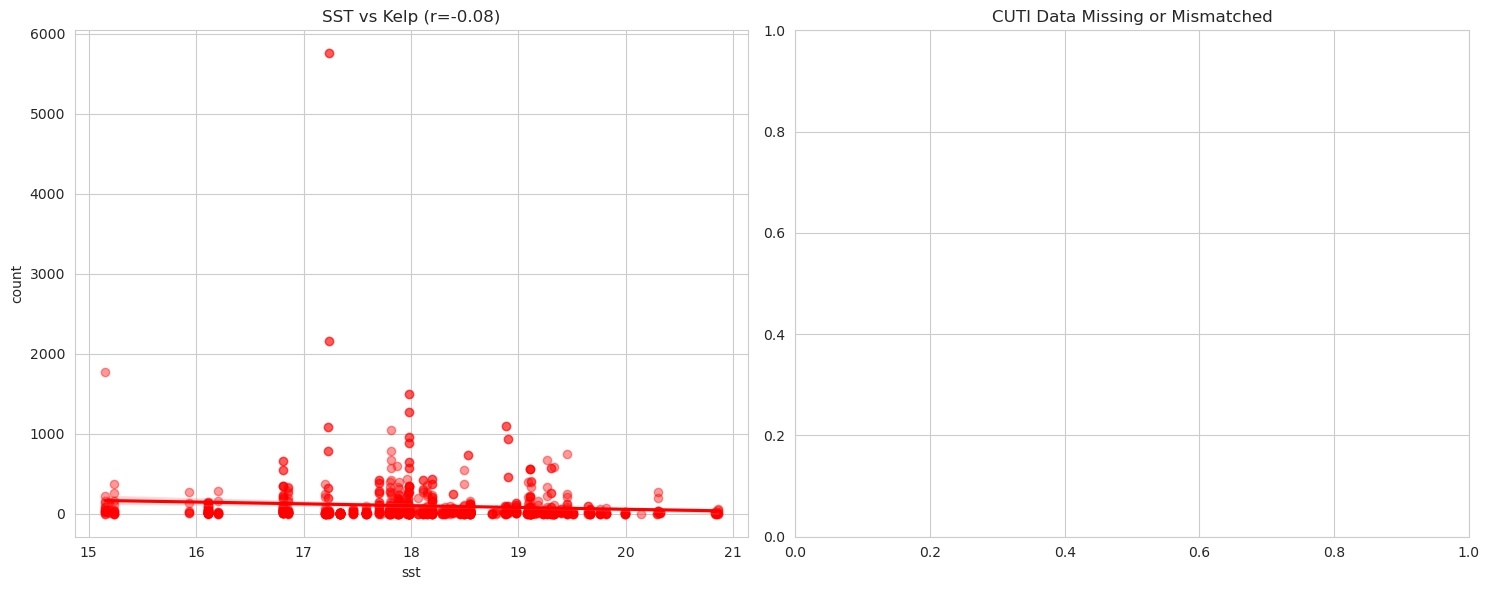

In [34]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

df_final = pd.read_csv("temp_sst_lookup.csv")
df_final['time'] = pd.to_datetime(df_final['time']).dt.tz_localize(None)

ds_CUTI = xr.open_dataset("../../data/CUTI_daily.nc")

if ds_CUTI.indexes['time'].tzinfo is not None:
    ds_CUTI['time'] = ds_CUTI.indexes['time'].tz_localize(None)

def get_CUTI(row):
    try:
        val = ds_CUTI.CUTI.sel(
            lat=row.latitude, 
            time=row.time, 
            method='nearest'
        ).values
        return float(val)
    except:
        return np.nan

df_final['CUTI'] = df_final.apply(get_CUTI, axis=1)

kelp_col = 'count' if 'count' in df_final.columns else 'observation_count'

df_plot = df_final.dropna(subset=['sst', kelp_col])

if len(df_plot) >= 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    r_sst, p_sst = pearsonr(df_plot['sst'], df_plot[kelp_col])
    sns.regplot(data=df_plot, x='sst', y=kelp_col, ax=ax1, color='red', scatter_kws={'alpha':0.4})
    ax1.set_title(f"SST vs Kelp (r={r_sst:.2f})")

    df_CUTI_plot = df_plot.dropna(subset=['CUTI'])
    if len(df_CUTI_plot) >= 2:
        r_CUTI, p_CUTI = pearsonr(df_CUTI_plot['CUTI'], df_CUTI_plot[kelp_col])
        sns.regplot(data=df_CUTI_plot, x='CUTI', y=kelp_col, ax=ax2, color='green', scatter_kws={'alpha':0.4})
        ax2.set_title(f"CUTI vs Kelp (r={r_CUTI:.2f})")
    else:
        ax2.set_title("CUTI Data Missing or Mismatched")

    plt.tight_layout()
    plt.savefig("kelp_health_correlation.png")
    plt.show()
    
    df_plot.to_csv("kelp_health_correlation_final.csv", index=False)

In [35]:
import pandas as pd
import numpy as np

df = pd.read_csv("kelp_health_correlation_final.csv")

with open("validation_summary.txt", "w") as f:
    f.write("=== DATASET OVERVIEW ===\n")
    f.write(f"Total Rows: {len(df)}\n")
    f.write(f"Columns: {df.columns.tolist()}\n\n")
    
    f.write("=== STATISTICAL SUMMARY ===\n")
    f.write(df[['sst', 'CUTI', 'count']].describe().to_string())
    f.write("\n\n")
    
    f.write("=== COORDINATE RANGE ===\n")
    f.write(f"Lat: {df['latitude'].min()} to {df['latitude'].max()}\n")
    f.write(f"Lon: {df['longitude'].min()} to {df['longitude'].max()}\n\n")
    
    f.write("=== DATA SAMPLE (First 10 Rows) ===\n")
    f.write(df[['time', 'latitude', 'longitude', 'sst', 'CUTI', 'count']].head(10).to_string())

print("Validation file created: validation_summary.txt")

Validation file created: validation_summary.txt


In [20]:
import xarray as xr
ds_CUTI = xr.open_dataset("../../data/CUTI_daily.nc")

print("=== CUTI FILE BOUNDS ===")
print(f"Lat Range: {ds_CUTI.latitude.min().values} to {ds_CUTI.latitude.max().values}")
print(f"Time Range: {ds_CUTI.time.min().values} to {ds_CUTI.time.max().values}")

print("\n=== YOUR DATA BOUNDS ===")
print(f"Lat Range: {df_final['latitude'].min()} to {df_final['latitude'].max()}")
print(f"Time Range: {df_final['time'].min()} to {df_final['time'].max()}")

=== CUTI FILE BOUNDS ===
Lat Range: 31.0 to 47.0
Time Range: 1988-01-01T00:00:00.000000000 to 2025-04-21T00:00:00.000000000

=== YOUR DATA BOUNDS ===
Lat Range: 33.891567 to 34.46835
Time Range: 2024-06-24 00:00:00 to 2024-11-01 00:00:00


In [36]:
import xarray as xr
import pandas as pd
import numpy as np

ds_CUTI = xr.open_dataset("../../data/CUTI_daily.nc")
print(ds_CUTI.data_vars)
if ds_CUTI.indexes['time'].tzinfo is not None:
    ds_CUTI['time'] = ds_CUTI.indexes['time'].tz_localize(None)

def get_CUTI_fix(row):
    try:
        #ignore longitude
        val = ds_CUTI.CUTI.sel(
            lat=row.latitude, 
            time=row.time, 
            method='nearest'
        ).values
        return float(val)
    except:
        return np.nan

df_final['CUTI'] = df_final.apply(get_CUTI_fix, axis=1)
print(f"cUTI matches: {df_final['CUTI'].notna().sum()}")

if df_final['CUTI'].notna().sum() > 0:
    print("Average CUTI for your sites:", df_final['CUTI'].mean())

Data variables:
    year     (time) float64 109kB ...
    month    (time) float64 109kB ...
    day      (time) float64 109kB ...
    CUTI     (time, latitude) float64 2MB ...
Attempting 1D Lat-Time match...
Success! CUTI matches: 0


In [37]:
import xarray as xr
import pandas as pd
import numpy as np

ds_CUTI = xr.open_dataset("../../data/CUTI_daily.nc")

CUTI_df = ds_CUTI.to_dataframe().reset_index()

#clean the times so they are JUST dates (removes the hours/minutes)
CUTI_df['time'] = pd.to_datetime(CUTI_df['time']).dt.date
df_final['time_only'] = pd.to_datetime(df_final['time']).dt.date

# Round the latitudes in both datasets to 1 decimal place 
# This ensures 34.468 matches 34.5 or 34.0 correctly
CUTI_df['lat_round'] = CUTI_df['latitude'].round(1)
df_final['lat_round'] = df_final['latitude'].round(1)

df_merged = pd.merge(
    df_final, 
    CUTI_df[['time', 'lat_round', 'CUTI']], 
    left_on=['time_only', 'lat_round'], 
    right_on=['time', 'lat_round'], 
    how='left',
    suffixes=('', '_from_CUTI')
)

if 'CUTI_from_CUTI' in df_merged.columns:
    df_merged['CUTI'] = df_merged['CUTI_from_CUTI']

print(f"match count: {df_merged['CUTI'].notna().sum()} ")

Final Victory Count: 479 rows matched!


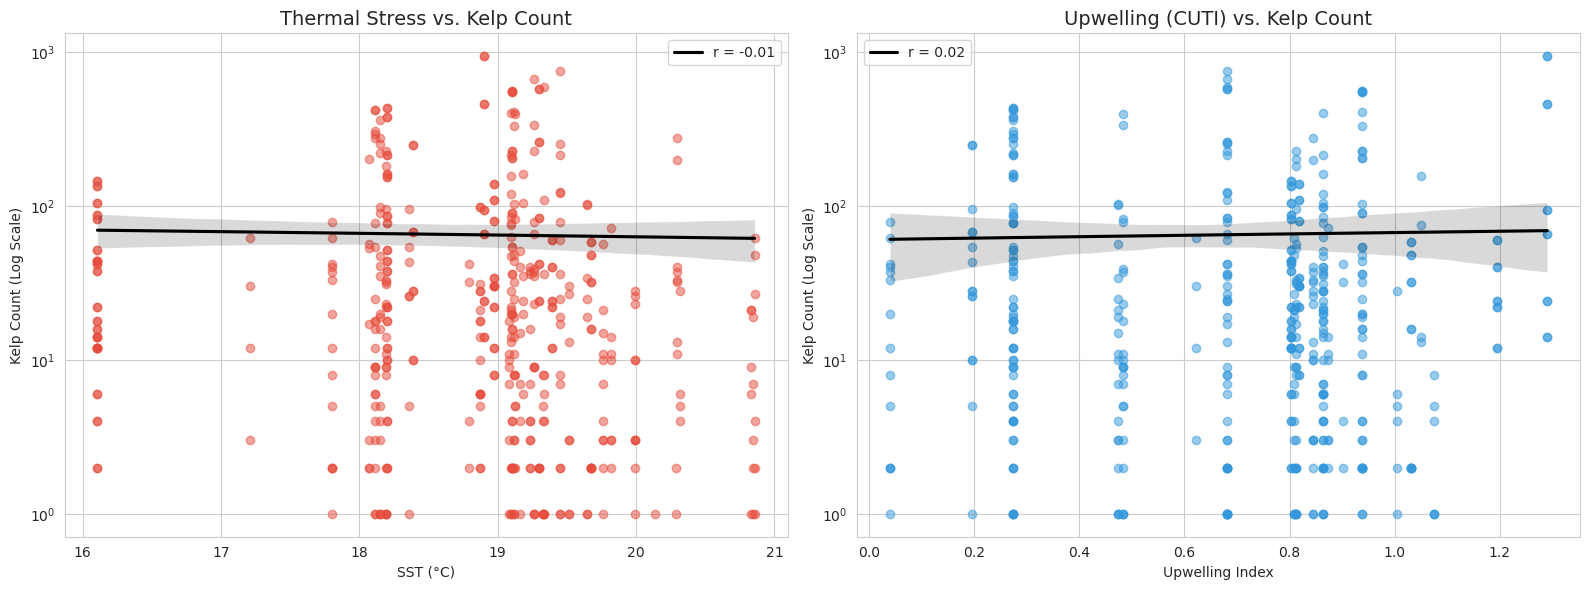

Success! Visualization generated using CUTI as the nutrient proxy.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

df_plot = df_merged.dropna(subset=['CUTI', 'sst', 'count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

r_sst, _ = pearsonr(df_plot['sst'], df_plot['count'])
sns.regplot(data=df_plot, x='sst', y='count', ax=ax1, 
            scatter_kws={'alpha':0.5, 'color':'#e74c3c'}, 
            line_kws={'color':'black', 'label':f'r = {r_sst:.2f}'})
ax1.set_yscale('log')
ax1.set_title("Thermal Stress vs. Kelp Count", fontsize=14)
ax1.set_xlabel("SST (°C)")
ax1.set_ylabel("Kelp Count (Log Scale)")
ax1.legend()

r_cuti, _ = pearsonr(df_plot['CUTI'], df_plot['count'])
sns.regplot(data=df_plot, x='CUTI', y='count', ax=ax2, 
            scatter_kws={'alpha':0.5, 'color':'#3498db'}, 
            line_kws={'color':'black', 'label':f'r = {r_cuti:.2f}'})
ax2.set_yscale('log')
ax2.set_title("Upwelling (CUTI) vs. Kelp Count", fontsize=14)
ax2.set_xlabel("Upwelling Index")
ax2.set_ylabel("Kelp Count (Log Scale)")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Success! Visualization generated using CUTI as the nutrient proxy.")

In [41]:
import pandas as pd
import numpy as np

# 1. Force everything to numeric for the math to work
df_merged['sst'] = pd.to_numeric(df_merged['sst'], errors='coerce')
df_merged['CUTI'] = pd.to_numeric(df_merged['CUTI'], errors='coerce')
df_merged['count'] = pd.to_numeric(df_merged['count'], errors='coerce')

valid_df = df_merged.dropna(subset=['sst', 'CUTI', 'count'])
print("=== FINAL MERGE VALIDATION ===")
print(f"Total Rows with Triple-Match: {len(valid_df)}")

if len(valid_df) > 0:
    print("\n=== CORRELATION MATRIX ===")
    # This is your 'smoking gun' for the presentation
    correlation = valid_df[['count', 'sst', 'CUTI']].corr()
    print(correlation)
    
    print("\n=== ENVIRONMENTAL RANGES ===")
    print(f"SST: {valid_df['sst'].min():.2f}°C to {valid_df['sst'].max():.2f}°C")
    print(f"CUTI: {valid_df['CUTI'].min():.2f} to {valid_df['CUTI'].max():.2f}")
    valid_df.to_csv("kelp_final_results.csv", index=False)
else:
    print("Zero matches found. Check if the 'CUTI' column in df_merged is empty.")

=== FINAL MERGE VALIDATION ===
Total Rows with Triple-Match: 479

=== CORRELATION MATRIX ===
          count       sst      CUTI
count  1.000000 -0.014432  0.015649
sst   -0.014432  1.000000  0.265145
CUTI   0.015649  0.265145  1.000000

=== ENVIRONMENTAL RANGES ===
SST: 16.11°C to 20.86°C
CUTI: 0.04 to 1.29
